# Amazon Fine Food Reviews Analysis

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

Number of reviews: 568,454 Number of users: 256,059 Number of products: 74,258 Timespan: Oct 1999 - Oct 2012 Number of Attributes/Columns in data: 10

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10.Text - text of the review

Objective:

Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

[Q] How to determine if a review is positive or negative?

[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.


# [1] Reading Data

## [1.1] Loading the data

The dataset is available in two forms

.csv file
SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".


In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import CountVectorizer


import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
import tqdm
from tqdm import tqdm
import os

from scipy.sparse import find
from numpy import random

# LR imports
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import LogisticRegression
#metrics imports
from sklearn import metrics
from sklearn.metrics import roc_curve,roc_auc_score,auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

C:\Users\Delhi\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Delhi\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
con = sqlite3.connect('database.sqlite')

#Normal for every dataset contains a score from 1 to 5. 
#The review must classified as positive or a negative reviews. Neutral reviews such score = 3 are omitted.
#We consider scores 1,2 as negative and 4,5 as positive.So we will consider reviews which are not equal to 3.

filtered_data = pd.read_sql_query("SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000", con)
filtered_data.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [3]:
# For Each review the scores will be 1,2 and 4,5.
# We will mark negative review as 0 and positive reviews as 1 for classification purposes
def partition(x) :
    if x > 3 :
        return 1
    return 0

actualscore = filtered_data['Score']
positivenegative = actualscore.map(partition)
filtered_data['Score'] = positivenegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [4]:
#Checking the database statistics
filtered_data.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,100000.000000,100000.000000,100000.000000,100000.000000,1.000000e+05
mean,54380.301200,1.645130,2.106580,0.838760,1.296128e+09
std,31372.425622,6.212261,6.832594,0.367754,4.781070e+07
min,1.000000,0.000000,0.000000,0.000000,9.486720e+08
25%,27298.750000,0.000000,0.000000,1.000000,1.270512e+09
50%,54294.500000,0.000000,1.000000,1.000000,1.311379e+09
75%,81583.250000,2.000000,2.000000,1.000000,1.332547e+09
max,108623.000000,559.000000,562.000000,1.000000,1.351210e+09


# 2. Exploratory data Analysis

## 2.1 Data Cleaning: Deduplication 

In [5]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId='ABXLMWJIXXAIN'
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,320691,B000CQ26E0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",0,0,4,1187740800,"Fast, Easy and organic","For speed and wholesome goodness, Annie's can ..."
1,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
2,468954,B004DMGQKE,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",0,0,5,1351209600,Awesome service and great products,We sent this product as a gift to my husband's...


From the above output we could observe that For a single UserId there are multiple reviews. So we need to sort the data and
delete the duplicate records based on the ProductId and UserId

In [6]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, 
                                      kind='quicksort', na_position='last')

In [7]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [8]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

Observation:- It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [9]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND HelpfulnessNumerator > HelpfulnessDenominator
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [10]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [11]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

score = final['Score']

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()


(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

# 3. Preprocessing¶

## 3.1 Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

    Begin by removing the html tags
    Remove any punctuations or limited set of special characters like , or . or # etc.
    Check if the word is made up of english letters and is not alpha-numeric
    Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
    Convert the word to lowercase
    Remove Stopwords
    Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)

After which we collect the words used to describe positive and negative reviews
 

In [12]:
sent_100 = final['Text'].values[100]
print("="*50)
print(sent_100)
print("="*50)

My Frenchbull is only given nylabone's to chew. He has had them since he was 7 weeks old. They are safe for him because he has a strong bite and they don't break off in large pieces that he could choke on. The Dinosaur Chew is perfect because it has so many places to hold and bite.  Dylabone is the only product I buy.


In [13]:
# Cleaning HTML tags
def cleanhtml(sentence):
    sent = re.sub(r"http\S+", "", sentence)
    return sent

In [14]:
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [15]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
def rmwrdswithnumbers(sentence):
    sent = re.sub("\S*\d\S*", "", sentence).strip()
    return sent

In [16]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
def rmspcchar(sentence):
    sent = re.sub('[^A-Za-z0-9]+', ' ', sentence)
    return sent

In [17]:
nltk.download('stopwords')

stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Delhi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = cleanhtml(sentance)
    sentance = decontracted(sentance)
    sentance = rmwrdswithnumbers(sentance)
    sentance = rmspcchar(sentance)
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████| 87773/87773 [00:16<00:00, 5354.64it/s]


In [19]:
preprocessed_reviews[100]

'frenchbull given nylabone chew since weeks old safe strong bite break large pieces could choke dinosaur chew perfect many places hold bite dylabone product buy'

# 3.2 Preprocessing Review Summary

In [20]:
from tqdm import tqdm
preprocessed_reviews_summary = []
for sentance in tqdm(final['Summary'].values):
    sentance = cleanhtml(sentance)
    sentance = decontracted(sentance)
    sentance = rmwrdswithnumbers(sentance)
    sentance = rmspcchar(sentance)
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews_summary.append(sentance.strip())

100%|█████████████████████████████████| 87773/87773 [00:02<00:00, 35941.02it/s]


In [21]:
preprocessed_reviews_summary[100]

'frenchbull dog loves nylabones'

In [22]:
# Splitting the data into train, cross validate and test (Train = 60%, CV = 20%, Test = 20%)
x_train1, x_test, y_train1, y_test = train_test_split(preprocessed_reviews, score, test_size=0.2, 
                                                    stratify=None, random_state=0)


In [23]:
x_train, x_cv, y_train, y_cv = train_test_split(x_train1, y_train1, test_size = 0.25, random_state = 0,
                                                       stratify = None)


# 4. Featurization

## 4.1 Bag of Words

In [24]:
#Vectorizing the data
bow_vect = CountVectorizer()
model = bow_vect.fit(x_train)
bow_train = model.transform(x_train)
bow_cv = bow_vect.transform(x_cv)
bow_test = bow_vect.transform(x_test)

## 4.2 TFIDF 

In [25]:
#*******TFIDF********************
tfidf = TfidfVectorizer(ngram_range=(1,2))
model = tfidf.fit(x_train)
tfidf_train = model.transform(x_train)
tfidf_cv = model.transform(x_cv)
tfidf_test = tfidf.transform(x_test)

## 4.3 W2V 

In [27]:
#********W2V*********************
#def w2v(preprocessed_reviews):
w2v_words = []
for sent in preprocessed_reviews:
    w2v_words.append(sent.split())

w2v = Word2Vec(w2v_words, min_count=5, size=50, workers=4)
w2v_words_list = list(w2v.wv.vocab)
print(len(w2v_words_list))

17561


## 4.3.1 Average W2V 

In [28]:
#********AvgW2V******************
#def Avgw2v(preprocessed_reviews):
avg_w2vs = []
for sent in tqdm(preprocessed_reviews):
    #initializing number of words
    n_words = 0
    #initializing vector of size of 50
    sent_vec = np.zeros(50)
    for word in sent.split():
        if word in w2v_words_list:
            #creating for each word is an vector
            vec = w2v.wv[word]
            sent_vec += vec
            n_words += 1
#if n_words != 0:
    sent_vec /= n_words
    avg_w2vs.append(sent_vec)

avg_w2vs = np.array(avg_w2vs)
    #return avg_w2vs
print(len(avg_w2vs))
print(len(x_test))

100%|██████████| 87773/87773 [19:47<00:00, 73.93it/s] 


87773
17555


In [29]:
np.isnan(avg_w2vs).any()

False

In [30]:
mask = ~np.any(np.isnan(avg_w2vs), axis=1)
avg_w2vs_new = avg_w2vs[mask]
final_new = final['Score'][mask]
print(avg_w2vs_new.shape)
print(final_new.shape)

(87773, 50)
(87773,)


In [32]:
#Splitting into train and test
avg_w2v_train1, avg_w2v_test, y_train1, y_test_avg = train_test_split(avg_w2vs_new, final_new, test_size=0.2, 
                                                                  stratify=None, random_state=0)
print(avg_w2v_test.shape)
print(y_test.shape)
avg_w2v_train, avg_w2v_cv, y_train_avg, y_cv_avg = train_test_split(avg_w2v_train1, y_train1, test_size=0.25, 
                                                                  stratify=None, random_state=0)

(17555, 50)
(17555,)


## 4.3.2 Tfidf W2V 

In [33]:
tfidf_vect = TfidfVectorizer(ngram_range=(1,2), min_df = 10, max_features = 5000)
tfidf = tfidf_vect.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_vect.get_feature_names(), list(tfidf_vect.idf_)))

In [34]:
#*********TfidfW2V*******************
#def tfidfw2v(preprocessed_reviews):
features = tfidf_vect.get_feature_names()
tfidf_w2vs = []
row = 0
for sent in tqdm(preprocessed_reviews):
    sent_vec = np.zeros(50)
    tfidf_sum = 0
    for word in sent.split():
        if(word in w2v_words_list and word in features):
            vec = w2v.wv[word]
            #tfidf_value = tfidf[row, features.index(word)]
            tfidf_value = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tfidf_value)
            tfidf_sum += tfidf_value
    #if(tfidf_sum != 0):
    sent_vec /= tfidf_sum
    tfidf_w2vs.append(sent_vec)
    #row += 1
tfidf_w2vs = np.array(tfidf_w2vs)
print(len(tfidf_w2vs))
#  return tfidf_w2vs

100%|██████████| 87773/87773 [25:26<00:00, 57.51it/s] 


87773


In [35]:
mask = ~np.any(np.isnan(tfidf_w2vs), axis=1)
tfidf_w2vs_new = tfidf_w2vs[mask]
final_new = final['Score'][mask]
print(tfidf_w2vs_new.shape)
print(final_new.shape)

(87773, 50)
(87773,)


In [46]:
tfidf_w2v_train1, xtf_w2v_test, score_tr_tfidf1, ytf_w2v_test = train_test_split(tfidf_w2vs_new, final_new,
                                                                                 test_size=0.2, stratify=None, random_state=0)
xtf_w2v_train, xtf_w2v_cv, ytf_w2v_train, ytf_w2v_cv = train_test_split(tfidf_w2v_train1, score_tr_tfidf1, 
                                                                        test_size=0.25, stratify=None, random_state=0)                                                                                    

In [26]:
#def gridsearch cv for Logistic regression with L1 regularization
def log_reg_train(x_train, y_train, pl):
    train_auc = []
    C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
    for i in C:
        log_model = LogisticRegression(C = i, penalty = pl)
        log_model.fit(x_train, y_train)
        pred_train = log_model.predict_proba(x_train)[:,1]
        train_auc.append(roc_auc_score(y_train,pred_train))
        print("for C = {0} the roc_auc_score is {1}". format(i, roc_auc_score(y_train,pred_train)))
    optimal_C = C[train_auc.index(max(train_auc))]
    return train_auc, optimal_C

In [27]:
def log_reg_cv(x_cv, y_cv, x_train, y_train, pl):
    cv_auc = []
    C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
    for i in C:
        model_cv = LogisticRegression(C = i, penalty = pl)
        model_cv.fit(x_train, y_train)
        pred_cv = model_cv.predict_proba(x_cv)[:,1]
        cv_auc.append(roc_auc_score(y_cv, pred_cv))
        print("for C = {0} the roc_auc_score is {1}". format(i, roc_auc_score(y_cv, pred_cv)))
    optimal_C_CV = C[cv_auc.index(max(cv_auc))]
    return cv_auc, optimal_C_CV

In [49]:
def param_tune(x_train, y_train, x_test, y_test, param, pl):
    lr = LogisticRegression(penalty = pl,C=param)
    lr.fit(x_train, y_train)
    pred = lr.predict(x_test)
    print('For C = {0} the area under AUC curve is = {1}\n'.format(param,roc_auc_score(y_test, pred)))
    return pred

In [50]:
def roc_curve(y_test, pred):
    #fpr1, tpr1, threshold1 = metrics.roc_curve(y_train1, lr.predict_proba(x_train)[:,1])
    fpr, tpr, threshold = metrics.roc_curve(y_test, pred)

    roc_auc = metrics.auc(fpr, tpr)
    #roc_auc1 = metrics.auc(fpr1, tpr1)

    plt.title("ROC Curve")
    plt.plot(fpr, tpr, 'b', label = 'ROC_test')
    #plt.plot(fpr1, tpr1, 'g', label = 'ROC_train')
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [111]:
def ploting_train_cv(C, train_auc, cv_auc):
    C = np.log(np.array(C))
    plt.plot(C, cv_auc, label = 'cv_auc')
    plt.plot(C, train_auc, label = 'train_auc')
    plt.xlabel('hyperparameter')
    plt.ylabel('area under AUC curve')
    plt.title("Train AUC vs Validate AUC")
    plt.grid()
    plt.legend()
    plt.show()

In [52]:
#def confusion_matrix()
def confus_mat(y_test, pred):
    co_mt = confusion_matrix(y_test,pred)
    class_label = ['negative', 'positive']
    df_conf_matrix = pd.DataFrame(co_mt, index=class_label, columns=class_label)
    sns.heatmap(df_conf_matrix, annot=True, fmt='d')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

In [168]:
#definition for top features 
def topfeatures(vectorizer):
    features = vectorizer.get_feature_names()
    coef_of_feat = sorted(zip(clf.coef_[0],features))
    print("Top 10 positive important features")
    for a in coef_of_feat[-10:]:
        print(a)
    print("-"*100)
    print("Top 10 negative important features:")
    print("-"*100)
    for a in coef_of_feat[:10]:
        print(a)

# Applying Logistic Regression

## 5.1 Applying Logistic Regression on BOW 

In [66]:

from sklearn import preprocessing
std_train_bow = preprocessing.normalize(bow_train)
std_cv_bow = preprocessing.normalize(bow_cv)
std_test_bow = preprocessing.normalize(bow_test)

### 5.1.1 Applying Logistic Regression with L1 regularization on BOW 

In [79]:
#calling logistic regression using Hyperparameter and L1 regularization on train data
pl = 'l1'
train_auc, optimal_C = log_reg_train(std_train_bow, y_train, pl)

for C = 0.0001 the roc_auc_score is 0.5
for C = 0.001 the roc_auc_score is 0.5
for C = 0.01 the roc_auc_score is 0.7215193091414618
for C = 0.1 the roc_auc_score is 0.8988560195955994
for C = 1 the roc_auc_score is 0.9550518617415518
for C = 10 the roc_auc_score is 0.9908537111072849
for C = 100 the roc_auc_score is 0.9997372348358033
for C = 1000 the roc_auc_score is 0.9999999880734164
for C = 10000 the roc_auc_score is 0.9999999933741203


In [80]:
optimal_C

10000

In [81]:
pl = 'l1'
cv_auc, optimal_C_CV = log_reg_cv(std_cv_bow, y_cv, std_train_bow, y_train, pl)
optimal_C_CV

for C = 0.0001 the roc_auc_score is 0.5
for C = 0.001 the roc_auc_score is 0.5
for C = 0.01 the roc_auc_score is 0.7144944513042818
for C = 0.1 the roc_auc_score is 0.8968599670501105
for C = 1 the roc_auc_score is 0.9429325139354986
for C = 10 the roc_auc_score is 0.9411285720934044
for C = 100 the roc_auc_score is 0.9081330551204801
for C = 1000 the roc_auc_score is 0.8877315996669064
for C = 10000 the roc_auc_score is 0.8723481187793288


1

### From the above we can see that highest AUC score is for alpha = 1, there by we will consdier it as our best alpha.

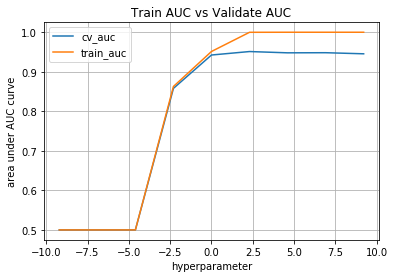

In [112]:
# plotting the acu and roc curves
C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
ploting_train_cv(C, train_auc, cv_auc)

In [83]:
# Hyperparameter tunning with best C again on train data and get AUC on test data 
# from the above we can say that best c is 5
C = optimal_C_CV
pl = 'l1'
pred = param_tune(std_train_bow, y_train, std_test_bow, y_test, C, pl)

For C = 1 the area under AUC curve is = 0.7963561429018273



### For optimal alpha 1 the area under AUC curve is 79.63. 

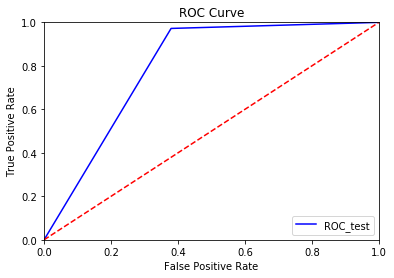

In [84]:
roc_curve(y_test, pred)

### As our ROC curve is above the diagnol line, we can consider it as a better simple linear model

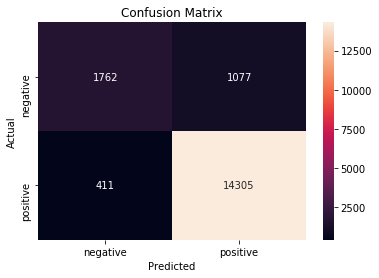

In [85]:
confus_mat(y_test, pred)

In [86]:
pl = 'l2'
train_auc, optimal_C = log_reg_train(std_train_bow, y_train, pl)
optimal_C

for C = 0.0001 the roc_auc_score is 0.648639003480829
for C = 0.001 the roc_auc_score is 0.8492247678269202
for C = 0.01 the roc_auc_score is 0.8775853195587336
for C = 0.1 the roc_auc_score is 0.9255010952764775
for C = 1 the roc_auc_score is 0.9593354373522988
for C = 10 the roc_auc_score is 0.9817885269584227
for C = 100 the roc_auc_score is 0.995773599105746
for C = 1000 the roc_auc_score is 0.9994523803136462
for C = 10000 the roc_auc_score is 0.9998916019322189


10000

In [87]:
pl = 'l2'
cv_auc, optimal_C_CV = log_reg_cv(std_cv_bow, y_cv, std_train_bow, y_train, pl)
optimal_C_CV

for C = 0.0001 the roc_auc_score is 0.6467634170922233
for C = 0.001 the roc_auc_score is 0.8454947579323745
for C = 0.01 the roc_auc_score is 0.8752810393176689
for C = 0.1 the roc_auc_score is 0.9193879262176637
for C = 1 the roc_auc_score is 0.9441152569919414
for C = 10 the roc_auc_score is 0.948699303256641
for C = 100 the roc_auc_score is 0.9388740394918719
for C = 1000 the roc_auc_score is 0.9176298911479988
for C = 10000 the roc_auc_score is 0.8989573357516405


10

### With l2 regularization, the best alpha on BOW is 10. So we will consider it as our optimal alpha 

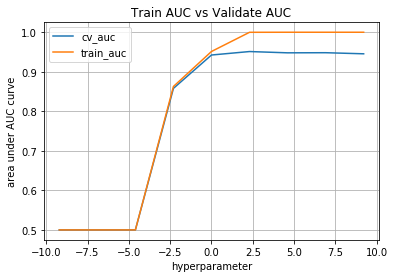

In [113]:
C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
ploting_train_cv(C, train_auc, cv_auc)

In [89]:
C = optimal_C_CV
pl = 'l2'
param_tune(std_train_bow, y_train, std_test_bow, y_test, C, pl)

For C = 10 the area under AUC curve is = 0.8223141281193748



array([1, 1, 0, ..., 1, 1, 0])

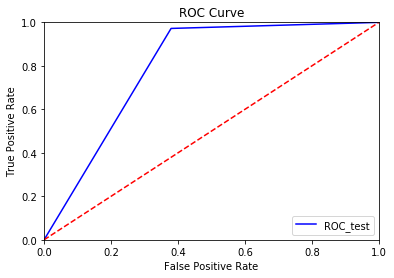

array([1, 1, 0, ..., 1, 1, 0])

In [90]:
roc_curve(y_test, pred)
pred

### As our ROC curve is above the diagnol line, we can consider it as a better simple linear model 

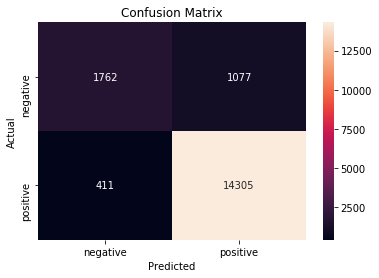

In [91]:
confus_mat(y_test, pred)

## Calculating sparsity on weight vector obtained using L1 regularization on BOW 

In [156]:
#Funtion for number of non zero elements
def nonzero_elements(x_train, y_train):
    C = [10000, 1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001] 
    for i in C:
        clf = LogisticRegression(penalty = 'l1', C = i)
        clf.fit(x_train,y_train)
        #getting the optimal 'W'
        opt_w = clf.coef_
        print("Number of non-zero elements in optimal vector for C = {} and L1 reg is {}:".
                  format(i, np.count_nonzero(opt_w)))
        if np.count_nonzero(opt_w) == 0:
            break

In [157]:
#To find number of non_zero elements with the C=1000 and l1_reg
nonzero_elements(std_train_bow, y_train)

Number of non-zero elements in optimal vector for C = 10000 and L1 reg is 12661:
Number of non-zero elements in optimal vector for C = 1000 and L1 reg is 11374:
Number of non-zero elements in optimal vector for C = 100 and L1 reg is 10805:
Number of non-zero elements in optimal vector for C = 10 and L1 reg is 6964:
Number of non-zero elements in optimal vector for C = 1 and L1 reg is 1335:
Number of non-zero elements in optimal vector for C = 0.1 and L1 reg is 179:
Number of non-zero elements in optimal vector for C = 0.01 and L1 reg is 7:
Number of non-zero elements in optimal vector for C = 0.001 and L1 reg is 0:


### We can see how drastically the sparsity decreases from 12661 non-zero weights(@ C=1000) to only 0 non-zero weights(@ C=0.001) when we use L1 Regularization

## Performing pertubation test (multicollinearity check) on BOW

In [96]:
#Pertubation test
clf = LogisticRegression(penalty='l2', C=10)
clf.fit(std_train_bow, y_train)
# Weight before adding noise
weights = find(clf.coef_[0])[2]
print(weights[:30])
print(weights.shape)

[-1.18617376e+00  9.92405009e-01  3.37706995e-02  1.05196718e-03
  8.43356590e-03 -3.53108422e-01  4.53948259e-03  3.47685490e-03
  3.55078010e-04 -2.84354469e-01  5.36137672e-01  4.50926366e-04
  6.42559492e-01 -9.85310319e-02  2.14444569e-03  2.13834120e-01
  1.08283770e-02  1.45042569e-02 -2.91300428e-01  7.13189772e-02
  1.53550793e-02  5.10015695e-01 -4.56881345e-01  4.04856197e-01
  1.65963563e-01  1.95290376e-02  7.65289172e-03  5.83585986e-02
  2.37097563e-01  7.53067941e-01]
(40668,)


In [97]:
bow_tr = std_train_bow
print(std_train_bow.shape)

epsilon = random.normal(0, 0.1, find(bow_tr)[0].size)
#Addling epsilon to new BOW vectorizer
a,b,c = find(bow_tr)
bow_tr[a,b] = epsilon + bow_tr[a,b]
print(bow_tr.shape)

(52663, 40668)
(52663, 40668)


In [98]:
#Finding the Weights after adding noise
clf1 = LogisticRegression(penalty='l2', C=10)
clf1.fit(bow_tr, y_train)
weights1 = find(clf1.coef_[0])[2]
print(weights1[:30])
print(weights1.shape)

[-1.56413449e+00  7.39288270e-01  6.92746061e-02  8.78640905e-03
  1.81698501e-01 -4.70251510e-01  1.12602173e-01  4.60161320e-03
  1.19122913e-03 -5.49828585e-01  5.92132793e-01  6.68731022e-03
 -1.58659365e+00  4.25155574e-02  1.63368492e-03  1.18008491e-01
  1.91076435e-02  1.00299953e-02 -6.17249508e-01  2.45296813e-01
  8.60620704e-02  7.13138891e-01 -8.49608215e-01  1.67864115e-02
 -1.24463650e-03 -3.32292489e-02 -2.38627581e-02  7.01496329e-01
  6.68031516e-01  1.58520335e+00]
(40668,)


In [99]:
#Calculating the differences
weight_diff = (abs(weights - weights1) / weights) * 100
weight_diff

array([ -31.86385835,   25.50538709,  105.13228087, ..., -196.28723038,
         63.09007674,  102.58903876])

In [100]:
# Computing percentile
def percentile(low,high,step,weights):
    for i in np.arange(low,high,step):
        print('The {}th percentile is: {}'.format(i,np.percentile(weights,i)))
percentile(0,110,10,weight_diff)

The 0th percentile is: -208534.9145260873
The 10th percentile is: -132.97163099659826
The 20th percentile is: -45.63319028830351
The 30th percentile is: 0.5365651535727203
The 40th percentile is: 21.823196161977542
The 50th percentile is: 43.994384787714196
The 60th percentile is: 68.73330094376341
The 70th percentile is: 96.689787785898
The 80th percentile is: 155.5992325960517
The 90th percentile is: 347.51246343121414
The 100th percentile is: 155125.39992630747


### From the above we can observe that there is a drastic change  after 90th percentile to 100th percentile. So we will further calculate percentile between 90 and 100

In [101]:
percentile(90,100.1,1,weight_diff)

The 90.0th percentile is: 347.51246343121414
The 91.0th percentile is: 387.9395702980556
The 92.0th percentile is: 436.84132162840365
The 93.0th percentile is: 495.3053801259455
The 94.0th percentile is: 574.5746660545021
The 95.0th percentile is: 691.3356465043448
The 96.0th percentile is: 845.7179117049086
The 97.0th percentile is: 1098.1515319460377
The 98.0th percentile is: 1553.3976296676246
The 99.0th percentile is: 2635.2477509900914
The 100.0th percentile is: 155125.39992630747


### From the above we can observe that there is a drastic change after 99th percentile and 100th percentile. So we will further calculate percentile between 98 and 100

In [102]:
percentile(98,100.1,.1,weight_diff)

The 98.0th percentile is: 1553.3976296676246
The 98.1th percentile is: 1632.9710260018298
The 98.19999999999999th percentile is: 1704.1709404140008
The 98.29999999999998th percentile is: 1783.3514228937938
The 98.39999999999998th percentile is: 1872.738738189481
The 98.49999999999997th percentile is: 1965.085299001366
The 98.59999999999997th percentile is: 2064.4872592813736
The 98.69999999999996th percentile is: 2198.020597762338
The 98.79999999999995th percentile is: 2329.738189203434
The 98.89999999999995th percentile is: 2484.2148947127075
The 98.99999999999994th percentile is: 2635.2477509900277
The 99.09999999999994th percentile is: 2884.862691197329
The 99.19999999999993th percentile is: 3179.7870355330265
The 99.29999999999993th percentile is: 3567.2777808647807
The 99.39999999999992th percentile is: 3969.9412660083294
The 99.49999999999991th percentile is: 4679.560343119921
The 99.59999999999991th percentile is: 5668.9415274151725
The 99.6999999999999th percentile is: 7029.170

### From the above we can observe that there is a drastic change after 90th percentile to 100th percentile. So we will further calculate percentile between 99.89 and 99.99

## Feature Importance on BOW 

In [169]:
# Top positive and Negative features 
topfeatures(bow_vect)

Top 10 positive important features
(8.372277029737305, 'yummy')
(8.407279373288883, 'highly')
(8.840612001779103, 'wonderful')
(9.281895080122714, 'hooked')
(9.343263557620507, 'delicious')
(9.518736904824442, 'awesome')
(9.64938747465288, 'perfect')
(9.69428144779639, 'excellent')
(9.723618529034471, 'satisfied')
(10.230516309128944, 'amazing')
----------------------------------------------------------------------------------------------------
Top 10 negative important features:
----------------------------------------------------------------------------------------------------
(-14.13825487280805, 'worst')
(-10.786918352390499, 'disappointment')
(-10.363793453554992, 'terrible')
(-10.172466310149439, 'hopes')
(-10.167543564978656, 'disappointing')
(-9.979605827402345, 'awful')
(-9.48347656212905, 'died')
(-9.47362254796828, 'threw')
(-9.402630621774094, 'bland')
(-9.30414875136226, 'horrible')


# 5.2 Logistic Regression on TFIDF

In [29]:
from sklearn import preprocessing
std_tfidf_train = preprocessing.normalize(tfidf_train)
std_tfidf_cv = preprocessing.normalize(tfidf_cv)
std_tfidf_test = preprocessing.normalize(tfidf_test)
print(std_tfidf_train.shape)
print(std_tfidf_cv.shape)
print(std_tfidf_test.shape)

(52663, 980946)
(17555, 980946)
(17555, 980946)


##  5.2.1 Applying Logistic Regression with L1 regularization on TFIDF 

In [107]:
pl = 'l1'
train_auc, optimal_C = log_reg_train(std_tfidf_train, y_train, pl)
optimal_C

for C = 0.0001 the roc_auc_score is 0.5
for C = 0.001 the roc_auc_score is 0.5
for C = 0.01 the roc_auc_score is 0.5
for C = 0.1 the roc_auc_score is 0.8628121520203901
for C = 1 the roc_auc_score is 0.9513367256565561
for C = 10 the roc_auc_score is 0.9998667204285251
for C = 100 the roc_auc_score is 0.9999999933741202
for C = 1000 the roc_auc_score is 0.9999999933741203
for C = 10000 the roc_auc_score is 0.9999999933741203


1000

In [31]:
pl = 'l1'
cv_auc, optimal_C_CV = log_reg_cv(std_tfidf_cv, y_cv, std_tfidf_train, y_train, pl)
optimal_C_CV

for C = 0.0001 the roc_auc_score is 0.5
for C = 0.001 the roc_auc_score is 0.5
for C = 0.01 the roc_auc_score is 0.5
for C = 0.1 the roc_auc_score is 0.857984035421957
for C = 1 the roc_auc_score is 0.9423939716295175
for C = 10 the roc_auc_score is 0.9511951500296475
for C = 100 the roc_auc_score is 0.9479302069380144
for C = 1000 the roc_auc_score is 0.9479284095299934
for C = 10000 the roc_auc_score is 0.944350450260425


10

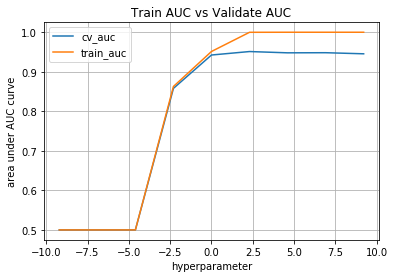

In [114]:
C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
ploting_train_cv(C, train_auc, cv_auc)

### With l1 regularization, the best alpha on TFIDF is 10. So we will consider it as our optimal alpha

In [115]:
C = optimal_C_CV
pl = 'l1'
pred = param_tune(std_tfidf_train, y_train, std_tfidf_test, y_test, C, pl)

For C = 10 the area under AUC curve is = 0.8370600906815632



###  For Tfidf, with alpha = 10 the AUC score is 83.70

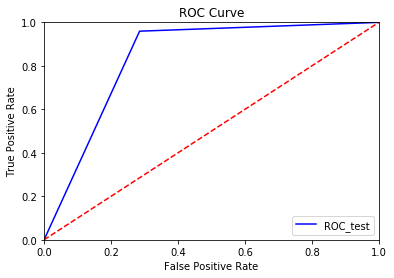

In [116]:
roc_curve(y_test, pred)

### From the above plotting the ROC curve is well above the diagnol line, which is better then simple linear model

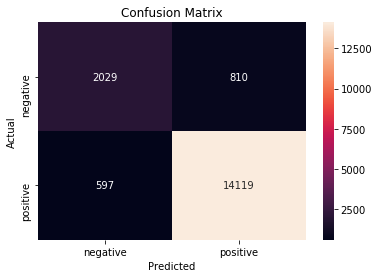

In [117]:
confus_mat(y_test, pred)

##  5.2.2 Applying Logistic Regression with L2 regularization on TFIDF 

In [118]:
pl = 'l2'
train_auc, optimal_C = log_reg_train(std_tfidf_train, y_train, pl)

for C = 0.0001 the roc_auc_score is 0.7005570014020308
for C = 0.001 the roc_auc_score is 0.9178625929082849
for C = 0.01 the roc_auc_score is 0.9303028411883748
for C = 0.1 the roc_auc_score is 0.9518453599915482
for C = 1 the roc_auc_score is 0.9881613511235342
for C = 10 the roc_auc_score is 0.9999757294024204
for C = 100 the roc_auc_score is 0.9999999933741203
for C = 1000 the roc_auc_score is 0.9999999933741203
for C = 10000 the roc_auc_score is 0.9999999933741203


In [119]:
pl = 'l2'
cv_auc, optimal_C_CV = log_reg_cv(std_tfidf_cv, y_cv, std_tfidf_train, y_train, pl)
optimal_C_CV

for C = 0.0001 the roc_auc_score is 0.6845970828164976
for C = 0.001 the roc_auc_score is 0.8983176406658804
for C = 0.01 the roc_auc_score is 0.9123833057131635
for C = 0.1 the roc_auc_score is 0.9290280326669679
for C = 1 the roc_auc_score is 0.949713818638033
for C = 10 the roc_auc_score is 0.9570669419842356
for C = 100 the roc_auc_score is 0.9577728861291497
for C = 1000 the roc_auc_score is 0.9576986823250375
for C = 10000 the roc_auc_score is 0.9576032253855415


100

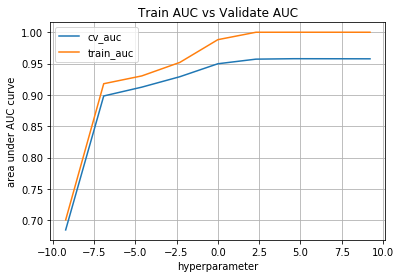

In [121]:
C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
ploting_train_cv(C, train_auc, cv_auc)

In [123]:
C = optimal_C_CV
pl = 'l2'
pred = param_tune(std_tfidf_train, y_train, std_tfidf_test, y_test, C, pl)

For C = 100 the area under AUC curve is = 0.8272011610502992



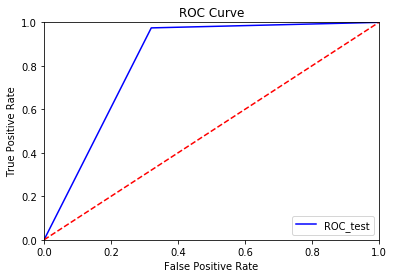

In [124]:
roc_curve(y_test, pred)

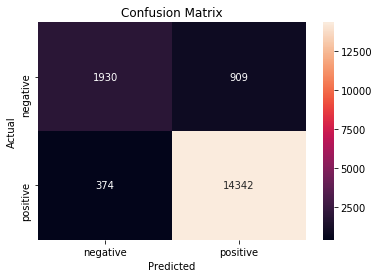

In [125]:
confus_mat(y_test, pred)

### 5.2.3 Feature Importance on TFIDF 

In [170]:
topfeatures(tfidf)

Top 10 positive important features
(8.372277029737305, 'around son')
(8.407279373288883, 'allergey also')
(8.840612001779103, 'around coupled')
(9.281895080122714, 'allergies gave')
(9.343263557620507, 'addtional')
(9.518736904824442, 'accumulate towards')
(9.64938747465288, 'amazing put')
(9.69428144779639, 'aftering sitting')
(9.723618529034471, 'anonymous worked')
(10.230516309128944, 'absorb better')
----------------------------------------------------------------------------------------------------
Top 10 negative important features:
----------------------------------------------------------------------------------------------------
(-14.13825487280805, 'around facility')
(-10.786918352390499, 'adoption told')
(-10.363793453554992, 'appealing maybe')
(-10.172466310149439, 'allergies health')
(-10.167543564978656, 'adoption shelter')
(-9.979605827402345, 'accumulating')
(-9.48347656212905, 'admit stores')
(-9.47362254796828, 'appears changed')
(-9.402630621774094, 'across filter')


# 5.3 Logistic Regression on AVG W2V

In [126]:
from sklearn import preprocessing
std_avg_w2v_train = preprocessing.normalize(avg_w2v_train)
std_avg_w2v_cv = preprocessing.normalize(avg_w2v_cv)
std_avg_w2v_test = preprocessing.normalize(avg_w2v_test)
print(std_avg_w2v_train.shape)
print(std_avg_w2v_cv .shape)
print(std_avg_w2v_test.shape)

(52663, 50)
(17555, 50)
(17555, 50)


## 5.3.1 Applying Logistic Regression with L1 regularization on AVG W2V

In [127]:
pl = 'l1'
train_auc, optimal_C = log_reg_train(std_avg_w2v_train, y_train_avg, pl)

for C = 0.0001 the roc_auc_score is 0.5
for C = 0.001 the roc_auc_score is 0.5
for C = 0.01 the roc_auc_score is 0.8868701251182898
for C = 0.1 the roc_auc_score is 0.9080843289287506
for C = 1 the roc_auc_score is 0.9084557890001417
for C = 10 the roc_auc_score is 0.9084492982883237
for C = 100 the roc_auc_score is 0.9084472204124294
for C = 1000 the roc_auc_score is 0.908446753950494
for C = 10000 the roc_auc_score is 0.9084462079780012


In [128]:
pl = 'l1'
cv_auc, optimal_C_CV = log_reg_cv(std_avg_w2v_cv, y_cv_avg, std_avg_w2v_train, y_train_avg, pl)
optimal_C_CV

for C = 0.0001 the roc_auc_score is 0.5
for C = 0.001 the roc_auc_score is 0.5
for C = 0.01 the roc_auc_score is 0.8844864887867486
for C = 0.1 the roc_auc_score is 0.9049348225846552
for C = 1 the roc_auc_score is 0.9058368056503512
for C = 10 the roc_auc_score is 0.905902896829071
for C = 100 the roc_auc_score is 0.9059111066116537
for C = 1000 the roc_auc_score is 0.9059106208257021
for C = 10000 the roc_auc_score is 0.9059110094544633


100

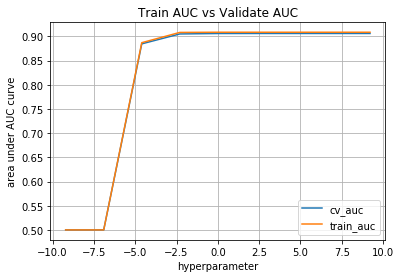

In [129]:
C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
ploting_train_cv(C, train_auc, cv_auc)

In [130]:
C = optimal_C_CV
pl = 'l1'
pred = param_tune(std_avg_w2v_train, y_train_avg, std_avg_w2v_test, y_test_avg, C, pl)

For C = 100 the area under AUC curve is = 0.7411706494434823



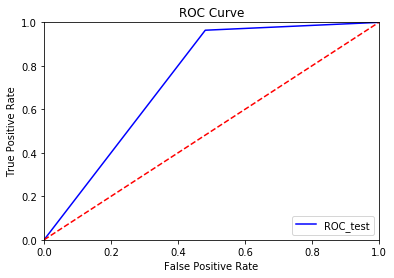

In [131]:
roc_curve(y_test_avg, pred)

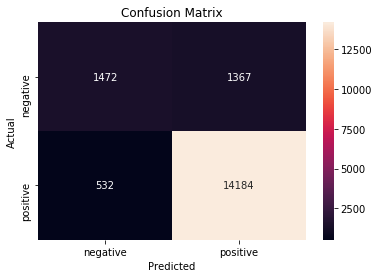

In [132]:
confus_mat(y_test_avg, pred)

## 5.3.2 Applying Logistic Regression with L2 regularization on AVG W2V 

In [133]:
pl = 'l2'
train_auc, optimal_C = log_reg_train(std_avg_w2v_train, y_train_avg, pl)

for C = 0.0001 the roc_auc_score is 0.736801597354372
for C = 0.001 the roc_auc_score is 0.8743348988272951
for C = 0.01 the roc_auc_score is 0.9013879232994306
for C = 0.1 the roc_auc_score is 0.9078113400320764
for C = 1 the roc_auc_score is 0.9084802331957711
for C = 10 the roc_auc_score is 0.9084516438497605
for C = 100 the roc_auc_score is 0.9084462662857433
for C = 1000 the roc_auc_score is 0.9084458077748634
for C = 10000 the roc_auc_score is 0.9084454314248928


In [134]:
pl = 'l2'
cv_auc, optimal_C_CV = log_reg_cv(std_avg_w2v_cv, y_cv_avg, std_avg_w2v_train, y_train_avg, pl)
optimal_C_CV

for C = 0.0001 the roc_auc_score is 0.7408505616511437
for C = 0.001 the roc_auc_score is 0.8733244878188687
for C = 0.01 the roc_auc_score is 0.8989882438828133
for C = 0.1 the roc_auc_score is 0.9052100203262557
for C = 1 the roc_auc_score is 0.9059214538524234
for C = 10 the roc_auc_score is 0.9059115681083078
for C = 100 the roc_auc_score is 0.905907949002968
for C = 1000 the roc_auc_score is 0.905907074588255
for C = 10000 the roc_auc_score is 0.9059068316952793


1

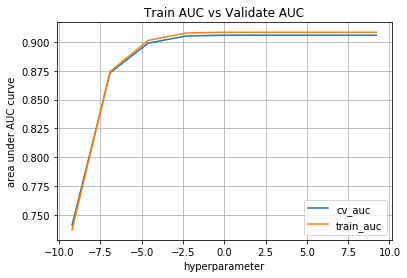

In [135]:
C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
ploting_train_cv(C, train_auc, cv_auc)

In [136]:
C = optimal_C_CV
pl = 'l2'
pred = param_tune(std_avg_w2v_train, y_train_avg, std_avg_w2v_test, y_test_avg, C, pl)

For C = 1 the area under AUC curve is = 0.7379416015673432



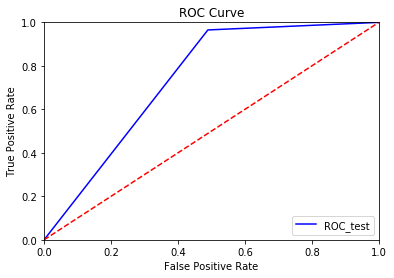

In [137]:
roc_curve(y_test_avg, pred)

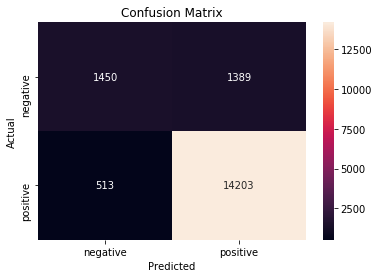

In [138]:
confus_mat(y_test_avg, pred)

# 5.4 Logistic Regression on Tfidf W2V

In [139]:
from sklearn import preprocessing
std_xtf_w2v_train = preprocessing.normalize(xtf_w2v_train)
std_xtf_w2v_cv = preprocessing.normalize(xtf_w2v_cv)
std_xtf_w2v_test = preprocessing.normalize(xtf_w2v_test)

## 5.4.1 Applying Logistic Regression with L1 regularization on TFIDF W2V

In [140]:
pl = 'l1'
train_auc, optimal_C = log_reg_train(std_xtf_w2v_train, ytf_w2v_train, pl)

for C = 0.0001 the roc_auc_score is 0.5
for C = 0.001 the roc_auc_score is 0.5
for C = 0.01 the roc_auc_score is 0.856139922901157
for C = 0.1 the roc_auc_score is 0.8814785009840731
for C = 1 the roc_auc_score is 0.8819761496104144
for C = 10 the roc_auc_score is 0.8819501682106795
for C = 100 the roc_auc_score is 0.8819475205091254
for C = 1000 the roc_auc_score is 0.881947080550709
for C = 10000 the roc_auc_score is 0.881947162711618


In [141]:
pl = 'l1'
cv_auc, optimal_C_CV = log_reg_cv(std_xtf_w2v_cv, ytf_w2v_cv, std_xtf_w2v_train, ytf_w2v_train, pl)
optimal_C_CV

for C = 0.0001 the roc_auc_score is 0.5
for C = 0.001 the roc_auc_score is 0.5
for C = 0.01 the roc_auc_score is 0.8538437910580214
for C = 0.1 the roc_auc_score is 0.8773019817443581
for C = 1 the roc_auc_score is 0.8780606093757272
for C = 10 the roc_auc_score is 0.878074259960968
for C = 100 the roc_auc_score is 0.8780763002619649
for C = 1000 the roc_auc_score is 0.8780702036482719
for C = 10000 the roc_auc_score is 0.8780768103372142


10000

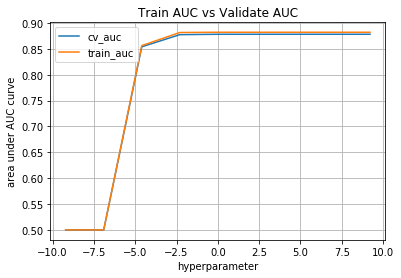

In [142]:
C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
ploting_train_cv(C, train_auc, cv_auc)

In [145]:
C = optimal_C
pl = 'l1'
pred = param_tune(std_xtf_w2v_train, ytf_w2v_train, std_xtf_w2v_test, ytf_w2v_test, C, pl)

For C = 1 the area under AUC curve is = 0.6904604003702938



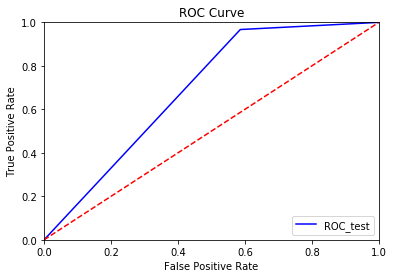

In [146]:
roc_curve(ytf_w2v_test, pred)

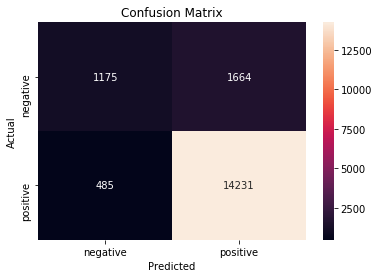

In [147]:
confus_mat(ytf_w2v_test, pred)

## 5.4.2 Applying Logistic Regression with L2 regularization on AVG W2V 

In [148]:
pl = 'l2'
train_auc, optimal_C = log_reg_train(std_xtf_w2v_train, ytf_w2v_train, pl)

for C = 0.0001 the roc_auc_score is 0.7106267775877104
for C = 0.001 the roc_auc_score is 0.843612011581423
for C = 0.01 the roc_auc_score is 0.8734562621144604
for C = 0.1 the roc_auc_score is 0.8810853265795158
for C = 1 the roc_auc_score is 0.8819609524925853
for C = 10 the roc_auc_score is 0.881948575349184
for C = 100 the roc_auc_score is 0.8819443321357825
for C = 1000 the roc_auc_score is 0.8819436827995654
for C = 10000 the roc_auc_score is 0.8819435264288029


In [149]:
pl = 'l2'
cv_auc, optimal_C_CV = log_reg_cv(std_xtf_w2v_cv, ytf_w2v_cv, std_xtf_w2v_train, ytf_w2v_train, pl)
optimal_C_CV

for C = 0.0001 the roc_auc_score is 0.7126612530032503
for C = 0.001 the roc_auc_score is 0.8419368130440136
for C = 0.01 the roc_auc_score is 0.870565442217267
for C = 0.1 the roc_auc_score is 0.8774528182823406
for C = 1 the roc_auc_score is 0.8781159889742134
for C = 10 the roc_auc_score is 0.8780779033556053
for C = 100 the roc_auc_score is 0.8780716852954245
for C = 1000 the roc_auc_score is 0.8780700093338913
for C = 10000 the roc_auc_score is 0.8780694749693445


1

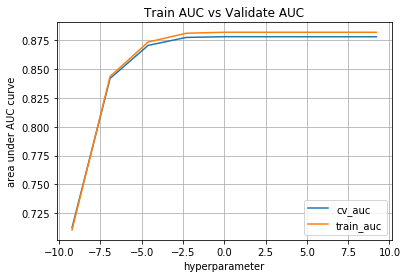

In [150]:
C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
ploting_train_cv(C, train_auc, cv_auc)

In [151]:
C = optimal_C_CV
pl = 'l2'
pred = param_tune(std_xtf_w2v_train, ytf_w2v_train, std_xtf_w2v_test, ytf_w2v_test, C, pl)


For C = 1 the area under AUC curve is = 0.6895271262951927



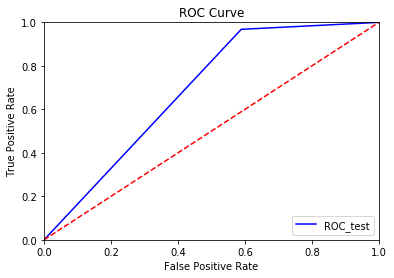

In [152]:
roc_curve(ytf_w2v_test, pred)

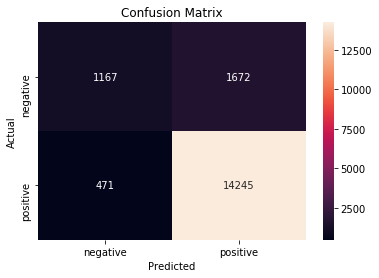

In [153]:
confus_mat(ytf_w2v_test, pred)

# 6. Conclusion

In [33]:
list_1 = [['BOW','L1',1, 79.63],
          ['BOW','L2',10, 82.23],
          ['TFIDF','L1',10, 83.07],
          ['TFIDF','L2',100, 82.72],
          ['AVG W2V','L1',100, 74.11],
          ['AVG W2V','L2',1, 73.79],
          ['TFIDF W2V','L1',1, 69.04],
          ['TFIDF W2V','L2',1, 68.95]]
columns= ['Vectorizer', 'Regularizer', 'Best alpha', 'AUC Score']
pd.DataFrame(list_1,columns = columns)

,Vectorizer,Regularizer,Best alpha,AUC Score
0,BOW,L1,1,79.63
1,BOW,L2,10,82.23
2,TFIDF,L1,10,83.07
3,TFIDF,L2,100,82.72
4,AVG W2V,L1,100,74.11
5,AVG W2V,L2,1,73.79
6,TFIDF W2V,L1,1,69.04
7,TFIDF W2V,L2,1,68.95
